In [12]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, func
from flask import Flask, jsonify
import datetime

In [13]:
import numpy as np
import pandas as pd

In [14]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [15]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [16]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [17]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine,reflect=True)
# reflect the tables

In [18]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [19]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [20]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [23]:
 inspector = inspect(engine)
inspector.get_table_names()
# Get a list of column names and types
columns = inspector.get_columns('Station')
for s in columns:
    print(s['name'], s["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [24]:
columns = inspector.get_columns('Measurement')
for M in columns:
    print(M['name'], M["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [48]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
print(last_date)

2017-08-23


In [50]:
# Calculate the date 1 year ago from the last data point in the database
last_year = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)
print(last_year)

2016-08-23 00:00:00


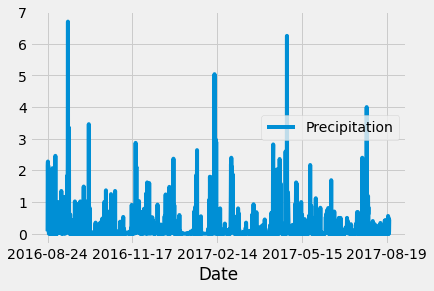

In [55]:

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date

# Calculate the date 1 year ago from the last data point in the database
last_year = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores (working with actual data)
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column 
preci_df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
preci_df.set_index('Date', inplace=True)
preci_df = preci_df.dropna()

# Use Pandas Plotting with Matplotlib to plot the data
ax = preci_df.plot().get_figure()
ax.savefig("output/Preci_lastyear.png")


In [56]:
preci_df.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


In [59]:
# Use Pandas to calcualte the summary statistics for the precipitation data
preci_df['Precipitation'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

In [62]:
# Design a query to show how many stations are available in this dataset?
locations = session.query(Station)
print("There are {} station.".format(locations.count()))

There are 9 station.


In [66]:
# What are the most active stations? (i.e. what stations have the most rows)?

active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [67]:
# List the stations and the counts in descending order.
most_active_station_location = ""
most_active_station = active_stations[0][0]

for location in locations:
    if(location.station == active_stations[0][0]):
        most_active_station_location = location.name
        
print(f"The most active stations information is: ")
print(f" Locations    : {most_active_station_location} ")
print(f" Station : {active_stations[0][0]}")
print(f" Count   : {active_stations[0][1]}")
print("")
print("List of the stations and the counts in descending order:")
print("Station        Counts")
print("-----------------------")
for active_station in active_stations:
    print(active_station[0], "   ", active_station[1])

The most active stations information is: 
 Locations    : WAIHEE 837.5, HI US 
 Station : USC00519281
 Count   : 2772

List of the stations and the counts in descending order:
Station        Counts
-----------------------
USC00519281     2772
USC00519397     2724
USC00513117     2709
USC00519523     2669
USC00516128     2612
USC00514830     2202
USC00511918     1979
USC00517948     1372
USC00518838     511


In [69]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_record = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

print(f"The Lowest, Highest & the average temperature for most active station {most_active_station} is :")
print(f" Low  : {temp_record[0][0]}")
print(f" High : {temp_record[0][1]}")
print(f" Avg  : {temp_record[0][2]}")

The Lowest, Highest & the average temperature for most active station USC00519281 is :
 Low  : 54.0
 High : 85.0
 Avg  : 71.66378066378067


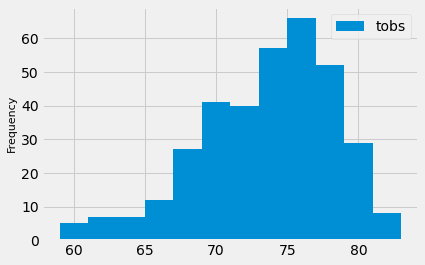

In [72]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and 
temp_result = session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.station == most_active_station).filter(Measurement.date >= last_year).\
    group_by(Measurement.date).all()
temp_result_df = pd.DataFrame(data=temp_result, columns=['date','tobs'])
temp_result_df = temp_result_df.set_index('date', drop=True)

##plot the results as a histogram
plt.hist(temp_result_df['tobs'],12, label="tobs")
plt.ylabel("Frequency", fontsize=11)
plt.legend()
plt.savefig("output/Temp_active.png")
plt.show()

## Bonus Challenge Assignment

In [130]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-12-28', '2013-01-05'))

[(62.0, 69.04918032786885, 78.0)]


In [131]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2016-12-28'
end_date = '2017-01-05'
tempresult = calc_temps(start_date,end_date)[0]
tempresult

(62.0, 69.27272727272727, 77.0)

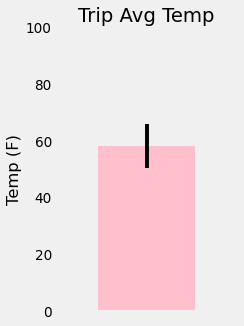

In [132]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_plot = [0]
y_plot = [tempresult[1]]
error = [(tempresult[2] - tempresult[1])]

plt.figure(figsize=(w, h), dpi=d)
plt.bar(x_pos,y_pos,color='pink', yerr=error)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xlim(-0.75,0.75)
plt.ylim(0, 100)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
plt.grid(which='major', axis='y', linestyle='-')
plt.savefig("output/Trip_Avg_Temp.png")
plt.show()

In [110]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2016-12-28'
end_date = '2017-01-05'

sel = [Measurement.station,func.sum(Measurement.prcp)]
rain_result = session.query(*sel).\
   group_by(Measurement.station).\
   filter(Measurement.date >= start_date).\
   filter(Measurement.date <= end_date).all()
station_df = pd.DataFrame(rain_result,columns=['Station','PrecSum'])

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
rain_result = session.query(*sel).all()
station_desc = pd.DataFrame(rain_result, columns=['Station','Name','Latitude','Longitude','Elevation'])

stations = pd.merge(station_desc,station_df, on="Station", how="left")
stations = stations.sort_values("PrecSum",ascending=False)
stations = stations.fillna(value = {'PrecSum':0})
stations = stations.reset_index(drop=True)
stations   

,Station,Name,Latitude,Longitude,Elevation,PrecSum
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.33
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.12
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.02
3,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.01
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00
5,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.00
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.00
7,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,0.00
8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,0.00


In [133]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [134]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
startdate = '2017-12-28'
enddate = '2018-01-05'

dtobj = dt.datetime.strptime(startdate, '%Y-%m-%d')
enddtobj = dt.datetime.strptime(enddate, '%Y-%m-%d')

tripdates = []
normals =[]
while (dtobj <= enddtobj):
    tripdates.append(dtobj)
    datestr = dt.datetime.strftime(dtobj,'%m-%d')
    normals.append(list(np.ravel(daily_normals(datestr))))
    dtobj = dtobj + dt.timedelta(days = 1)

normals

[[62.0, 70.52083333333333, 77.0],
 [57.0, 70.29166666666667, 78.0],
 [63.0, 69.86363636363636, 76.0],
 [56.0, 68.27906976744185, 77.0],
 [62.0, 69.15384615384616, 77.0],
 [60.0, 69.39622641509433, 77.0],
 [62.0, 68.9090909090909, 77.0],
 [58.0, 70.0, 76.0],
 [56.0, 67.96428571428571, 76.0]]

In [135]:


# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
tripstory = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
tripstory['Date'] = tripdates
tripstory = tripstory.set_index("Date")
tripstory

,tmin,tavg,tmax
Date,,,
2017-12-28,62.0,70.520833,77.0
2017-12-29,57.0,70.291667,78.0
2017-12-30,63.0,69.863636,76.0
2017-12-31,56.0,68.279070,77.0
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


In [136]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tripstory = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
tripstory['Date'] = tripdates
tripstory = tripstory.set_index("Date")

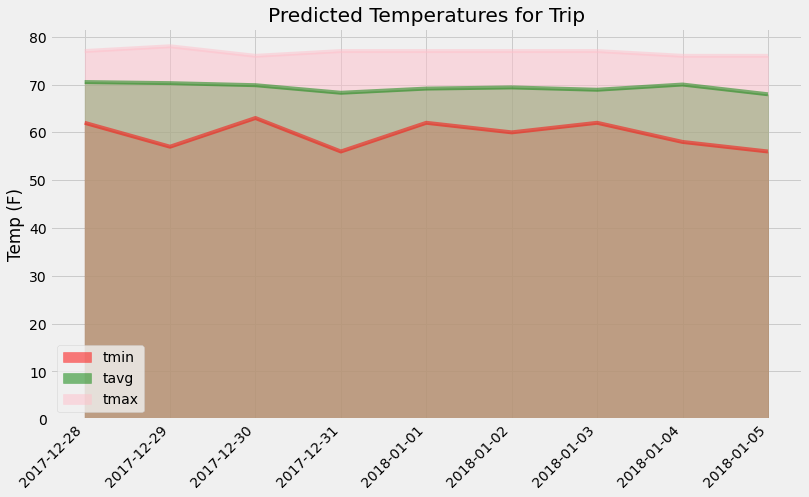

In [137]:
# Plot the daily normals as an area plot with `stacked=False`
colors = ['red', 'green', 'pink']

tripstory.plot(kind='area', figsize=(12, 8), stacked=False, x_compat=True, color=colors, alpha=.5, title='Predicted Temperatures for Trip', rot=45)
plt.xlabel('')
plt.ylabel('Temp (F)')
plt.savefig("output/temp_for_trip.png")
plt.show()